# Fake News Detector - EDA Analysis
The notebook covers the Explanatory Data Analysis of the ISOT Fake News detection dataset, provided by Kaggle.

The Kaggle Link : *https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset*



In [1]:
# Step 1: Install required packages
!pip install kagglehub[hf-datasets] datasets seaborn wordcloud pandas numpy --quiet

In [10]:
# Step 2: Import libraries
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from wordcloud import WordCloud
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.feature_extraction.text import CountVectorizer
import kagglehub
from kagglehub import KaggleDatasetAdapter
from datasets import Dataset
from pathlib import Path

## Data loading from Kaggle

In [3]:
# Load datasets directly from Kaggle
def load_dataset():
    print("⏳ Loading datasets from Kaggle...")
    fake_ds = kagglehub.load_dataset(
        KaggleDatasetAdapter.HUGGING_FACE,
        "clmentbisaillon/fake-and-real-news-dataset",
        "Fake.csv",
        hf_kwargs={"split": "all"}
    )

    true_ds = kagglehub.load_dataset(
        KaggleDatasetAdapter.HUGGING_FACE,
        "clmentbisaillon/fake-and-real-news-dataset",
        "True.csv",
        hf_kwargs={"split": "all"}
    )

    # Convert to pandas DataFrames
    fake_df = fake_ds.to_pandas()
    fake_df['label'] = 1  # Fake news

    true_df = true_ds.to_pandas()
    true_df['label'] = 0  # Real news

    # Combine datasets
    df = pd.concat([fake_df, true_df], ignore_index=True)

    print(f"✅ Dataset loaded: {len(df)} records")
    print(f"   - Fake news: {len(fake_df)} samples")
    print(f"   - Real news: {len(true_df)} samples")

    return df

# Load the data
full_df = load_dataset()

# Preview
full_df.sample(5)

⏳ Loading datasets from Kaggle...


<ipython-input-3-08a61bc710a0>:4: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  fake_ds = kagglehub.load_dataset(
<ipython-input-3-08a61bc710a0>:11: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  true_ds = kagglehub.load_dataset(


✅ Dataset loaded: 44898 records
   - Fake news: 23481 samples
   - Real news: 21417 samples


,title,text,subject,date,label
12780,DID HILLARY REALLY THINK She’d Get Away With T...,It s not a big surprise given her propensity f...,politics,"Oct 9, 2016",1
537,REPORTS: Charlottesville Fallout Was The Fina...,White House Chief Strategist Stephen K. Bannon...,News,"August 18, 2017",1
15834,"PRO ABORTION PAC, Emily’s List Doing Its Part ...",Of course Emily s List is going to support Hil...,politics,"Apr 13, 2015",1
37242,"Bulgarian, Macedonian Orthodox Churches edge c...",SOFIA (Reuters) - The Bulgarian Orthodox Churc...,worldnews,"November 27, 2017",0
7258,California Democrats To Raise Minimum Wage In...,California Democrats are taking a page from Or...,News,"March 27, 2016",1


## Explanatory Data Analysis

In [4]:
# Basic dataset stats
print("\n📊 Dataset Statistics:")
print(full_df.info())
print("\nLabel Distribution:")
print(full_df['label'].value_counts())


📊 Dataset Statistics:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
None

Label Distribution:
label
1    23481
0    21417
Name: count, dtype: int64


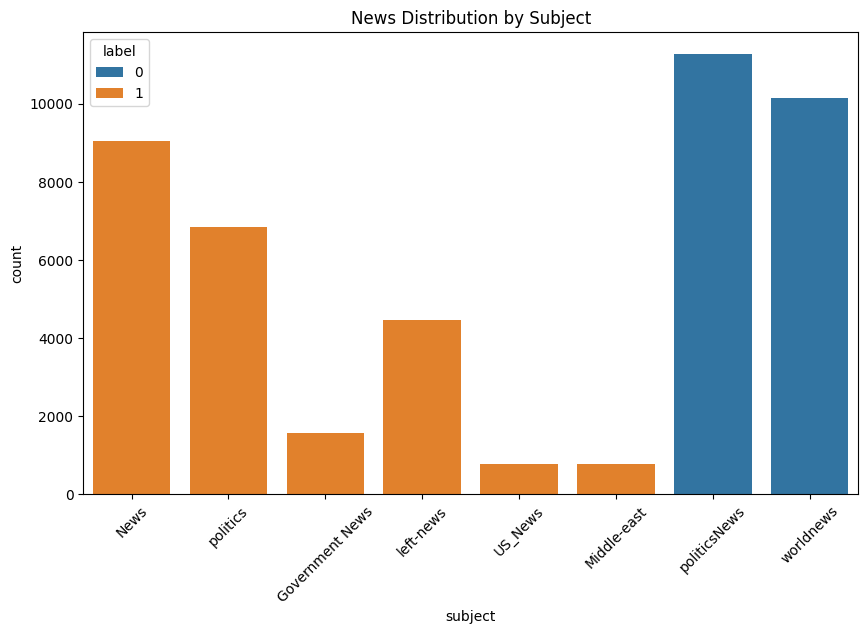

In [5]:
# Subject distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=full_df, x='subject', hue='label')
plt.title('News Distribution by Subject')
plt.xticks(rotation=45)
plt.show()

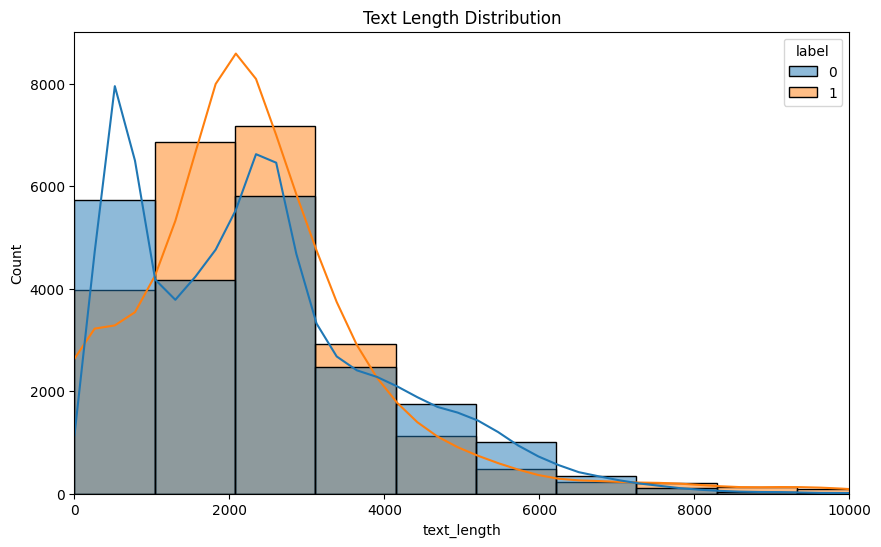

In [6]:
# Text length analysis
full_df['text_length'] = full_df['text'].apply(lambda x: len(str(x)))
plt.figure(figsize=(10, 6))
sns.histplot(data=full_df, x='text_length', hue='label', bins=50, kde=True)
plt.title('Text Length Distribution')
plt.xlim(0, 10000)  # Limit to 10k characters for better visualization
plt.show()

## Word Cloud

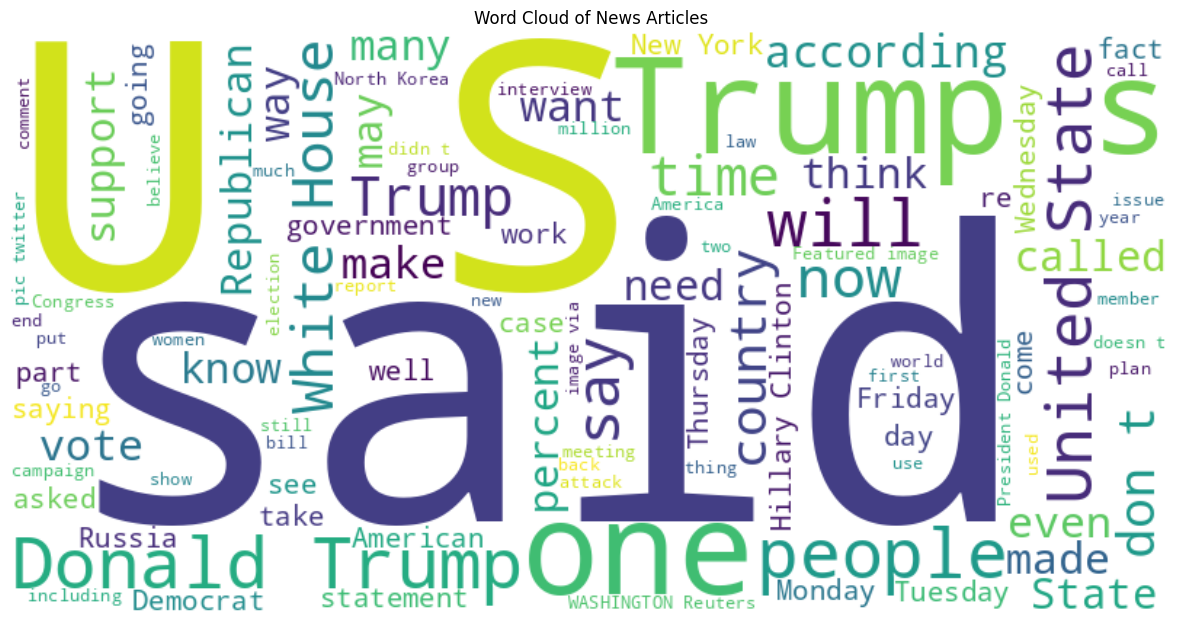

In [8]:
# Concatenate all text for the word cloud
all_text = " ".join(full_df['text'].dropna())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, random_state=21, max_words=100, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud of News Articles')
plt.show()

## n-gram frequency

In [11]:
def generate_ngrams(text, n=2):
    """Generates n-grams from text."""
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(text)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq

# Example usage: Generate bigram frequencies
bigrams = generate_ngrams(full_df['text'].dropna(), n=2)
print("\nTop 20 Bigrams:")
print(bigrams[:20])

# Example usage: Generate trigram frequencies
trigrams = generate_ngrams(full_df['text'].dropna(), n=3)
print("\nTop 20 Trigrams:")
print(trigrams[:20])


Top 20 Bigrams:
[('of the', np.int64(101795)), ('in the', np.int64(81021)), ('to the', np.int64(50064)), ('on the', np.int64(35662)), ('for the', np.int64(31531)), ('donald trump', np.int64(26443)), ('and the', np.int64(26404)), ('to be', np.int64(26306)), ('that the', np.int64(24923)), ('at the', np.int64(23771)), ('with the', np.int64(23079)), ('the united', np.int64(21131)), ('by the', np.int64(20714)), ('from the', np.int64(19159)), ('united states', np.int64(18867)), ('said the', np.int64(15397)), ('white house', np.int64(15161)), ('has been', np.int64(14357)), ('according to', np.int64(14109)), ('that he', np.int64(13950))]

Top 20 Trigrams:
[('the united states', np.int64(18241)), ('the white house', np.int64(9904)), ('one of the', np.int64(7031)), ('president donald trump', np.int64(6891)), ('pic twitter com', np.int64(6148)), ('featured image via', np.int64(5714)), ('said in statement', np.int64(4285)), ('according to the', np.int64(4150)), ('secretary of state', np.int64(399